## Neural Ratio Estimation

Here rather than estimating $P(\theta|D)$ as with a NPE we are putting parameter samples and data in to the classifier network and the network is returning the ratio

$r = \frac{P(D, \theta)}{P(D)P(\theta)} = \frac{P(D|\theta)P(\theta)}{P(D)P(\theta)} = \frac{P(D|\theta)}{P(D)} = \frac{L(\theta)}{Z}$

As usual we will start by importing the necessary libraries.

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random


We first generate a set of example gaussian absorption features from some prior. We sample our prior uniformly for the amplitude, width and central redshift of the signal and generate 100,000 example signals for training and testing.

Normally our simulation would include noise (since our real observation is noisey) but I am leaving noise out (of simulations and data) for simplicity.

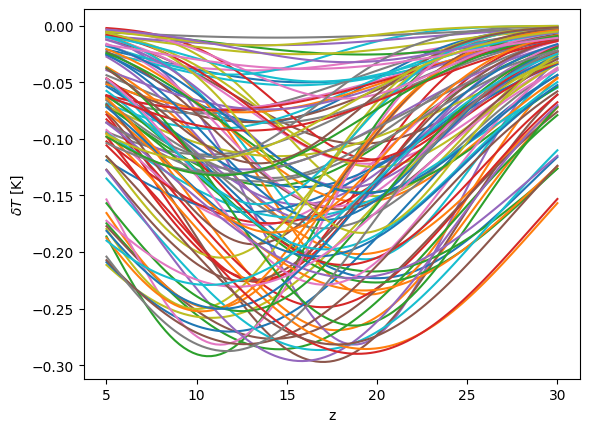

In [2]:
def gaussian(parameters):
    """a simple Gaussian function"""
    return -parameters[0] * \
        np.exp(-0.5*(z - parameters[1])**2/
               parameters[2]**2)

def prior(n):
    """a simple prior"""
    theta = np.ones((n, 3))
    theta[:, 0] = np.random.uniform(0.01, 0.3, n) # amplitude
    theta[:, 1] = np.random.uniform(10, 20, n) # mean
    theta[:, 2] = np.random.uniform(5, 10, n) # width
    return theta

z = np.linspace(5, 30, 100)[::-1]
n = 100000
theta = prior(n).astype(np.float32)
theta_min = np.array([0.01, 10, 5]).astype(np.float32)
theta_max = np.array([0.3, 20, 10]).astype(np.float32)
dims = theta.shape[1]
signals = np.array([gaussian(theta[i]) for i in range(n)])

[plt.plot(z, signals[i]) for i in range(100)]
plt.xlabel('z')
plt.ylabel(r'$\delta T$ [K]')
plt.savefig('example_signals.png', dpi=300, bbox_inches='tight')


Our classifier neural network is learning which parameters are needed to generate which data set and so it needs examples of matching parameters and signals $s = \{D(\theta), \theta\}$ which we label as 1 (they definitely go together) and mismatched parameters and signals $s' = \{D(\theta), \phi\}$ which we label as 0. The code below takes the generated signals and parameters, normalises them appropriately and stacks them into labelled pairs of matched and mismatched data and parameters.

We could do data compression here but we leave this out. Here the input data is a vector of length 103 (100 redshift data points per signal and 3 parameters) and the network can cope with this but in other scenarios our data vector might be of length 10,000 making the network hard to train without PCA, IMNN or some other form of data compression.

In [3]:
norm_signals = (signals - signals.mean())/signals.std()
norm_params = (theta- theta.mean(axis=0))/theta.std(axis=0)

norm_data = np.hstack([norm_signals, norm_params])
norm_labels = np.ones(n)

idx = np.arange(0, len(norm_data))
random.shuffle(idx)
shuffled_params = norm_params[idx, :]
shuffled_data = np.hstack([norm_signals, shuffled_params])
shuffled_labels = np.zeros(n)

data = np.vstack([shuffled_data, norm_data])
labels = np.hstack([shuffled_labels, norm_labels])

idx = np.arange(0, 2*n)
random.shuffle(idx)
data = data[idx, :]
labels = labels[idx]


Next we set up the neural network. Again we are using the ADAM optimizer. The network is a fully connected archtecture like we used for the 21cm emulator in the previous lecture but I've added Batch Normalisation and specified a particular kernel initializer. 

Batch normalisation essentially normalises the hyperparaemters of the network during training. The logic being that we normalise the inputs and outputs of our network so why not the actual hyperparameters too. There are some clever tricks required to deal with the fact that the normalisation will vary with each batch but tensorflow takes care of this for us.

When we first generate a neural network tensorflow randomly assigns some values for the hyperparameters. This is why you get different answers when training the same network twice on the same data. The thing that changed is the random seed and so the initial weights are different. The kernel initialisation is a perscription for how to set the random weights and here I am using a GlorotNormal scheme which seems to work well. It is not recommended to fix the random seed instead you should really make sure that your network gives good results for any random seed.

In [4]:
optimizer = tf.keras.optimizers.legacy.Adam(
                learning_rate=1e-3)

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(norm_data.shape[1], activation='sigmoid'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(100, activation='sigmoid',
                        kernel_initializer=tf.keras.initializers.GlorotNormal()),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(100, activation='sigmoid',
                        kernel_initializer=tf.keras.initializers.GlorotNormal()),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.Dense(1, activation='linear',
                        kernel_initializer=tf.keras.initializers.GlorotNormal()),
])

Next we define our loss function. The loss function is the key here. If we start to fiddle with it then what the network predicts is no longer $r$ so we need to make use we are using the binary cross entropy loss

$L = \frac{!}{N} \sum_i y_i \log (f(D_i, \theta_i)) + (1-y_i) \log(1 - f(D_i, \theta_i))$

where $f(D_i, \theta_i) = \sigma(\log r(D_i, \theta_i))$, $\sigma$ is the sigmoid activation function and $y_i$ is the label that goes with the pair of $D_i$ and $\theta_i$. The sigmoid activation scales $\log r$ to be between 0 and 1.

When using this loss funciton the network actually predicts $\log r$. You'll notice that when laying out the architecture of our classifier in the previous code snippet we set the activation function to be linear. We could in theory set this to a sigmoid activation however we would then have to invert this sigmoid when making predictions to get back to $\log r$ and this is not very numerically stable. Instead we put our prediction from the network through the sigmoid in the loss functions below.

In [5]:
@tf.function(jit_compile=True)
def _test_step(param, truth):
        
    r"""
    This function is used to calculate the loss value at each epoch and
    adjust the weights and biases of the neural networks via the
    optimizer algorithm.
    """
    prediction = tf.transpose(model(param, training=True))[0]
    prediction = tf.keras.layers.Activation('sigmoid')(prediction)
    truth = tf.convert_to_tensor(truth)
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(truth, prediction)
    return loss

@tf.function(jit_compile=True)
def _train_step(params, truth):

    r"""
    This function is used to calculate the loss value at each epoch and
    adjust the weights and biases of the neural networks via the
    optimizer algorithm.
    """

    with tf.GradientTape() as tape:
        prediction = tf.transpose(model(params, training=True))[0]
        prediction = tf.keras.layers.Activation('sigmoid')(prediction)
        truth = tf.convert_to_tensor(truth)
        loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)(truth, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(
        zip(gradients,
            model.trainable_variables))
    return loss


Once we have our training data and our loss function we can go ahead and train the classifier. This is a similar set up to the NPE we previously looked at. Again we are using early stopping to prevent over fitting. We have to keep track of labels, parameters and data simulations here but tensorflow has some nice tools to help with this.

A good thing to note is that a classifier between two equally represented classes with a binary cross entropy loss function will return a loss of approximately 0.68 if it can't learn the difference between the classes.

2024-02-28 12:04:06.613469: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2db88d130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-02-28 12:04:06.613481: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-02-28 12:04:06.628444: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-28 12:04:06.932777: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-02-28 12:04:06.933978: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


Epoch: 0 Loss: 0.28218 Test Loss: 0.11353
Epoch: 1 Loss: 0.09281 Test Loss: 0.05542
Epoch: 2 Loss: 0.06065 Test Loss: 0.04589
Epoch: 3 Loss: 0.04918 Test Loss: 0.04637
Epoch: 4 Loss: 0.03766 Test Loss: 0.02343
Epoch: 5 Loss: 0.03125 Test Loss: 0.02123
Epoch: 6 Loss: 0.02943 Test Loss: 0.01679
Epoch: 7 Loss: 0.02603 Test Loss: 0.02039
Epoch: 8 Loss: 0.02286 Test Loss: 0.01199
Epoch: 9 Loss: 0.02223 Test Loss: 0.01419
Epoch: 10 Loss: 0.01836 Test Loss: 0.01578
Epoch: 11 Loss: 0.02003 Test Loss: 0.01540
Epoch: 12 Loss: 0.01849 Test Loss: 0.01211
Epoch: 13 Loss: 0.01692 Test Loss: 0.01402
Epoch: 14 Loss: 0.01697 Test Loss: 0.01479
Epoch: 15 Loss: 0.01553 Test Loss: 0.01391
Epoch: 16 Loss: 0.01608 Test Loss: 0.00904
Epoch: 17 Loss: 0.01538 Test Loss: 0.01280
Epoch: 18 Loss: 0.01465 Test Loss: 0.01132
Epoch: 19 Loss: 0.01566 Test Loss: 0.01246
Epoch: 20 Loss: 0.01407 Test Loss: 0.01921
Epoch: 21 Loss: 0.01234 Test Loss: 0.00804
Epoch: 22 Loss: 0.01104 Test Loss: 0.01075
Epoch: 23 Loss: 0.014

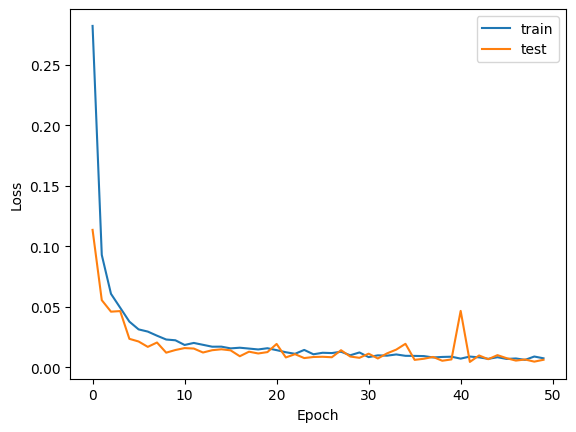

In [6]:

epochs = 50
batch_size = 300
patience = 10

data_train, data_test, labels_train, labels_test = \
        train_test_split(data, labels, test_size=0.2)

train_dataset = np.hstack([data_train, labels_train[:, np.newaxis]]).astype(np.float32)
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset)
train_dataset = train_dataset.batch(batch_size)

loss_history = []
test_loss_history = []
c = 0
#for i in tqdm.tqdm(range(epochs)):
for i in range(epochs):

    epoch_loss_avg = tf.keras.metrics.Mean()

    loss = [_train_step(x[:, :-1], x[:, -1]) for x in  train_dataset]
    epoch_loss_avg.update_state(loss)
    loss_history.append(epoch_loss_avg.result())

    test_loss_history.append(_test_step(data_test, labels_test))
    print('Epoch: {} Loss: {:.5f} Test Loss: {:.5f}'.format(
        i, loss_history[-1], test_loss_history[-1]))

    c += 1
    if i == 0:
        minimum_loss = test_loss_history[-1]
        minimum_epoch = i
        minimum_model = model
    else:
        if test_loss_history[-1] < minimum_loss:
            minimum_loss = test_loss_history[-1]
            minimum_epoch = i
            minimum_model = model
            c = 0
    if minimum_model:
        if c == patience:
            print('Early stopped. Epochs used = ' + str(i) +
                    '. Minimum at epoch = ' + str(minimum_epoch))
            model = minimum_model
            break

plt.plot(loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_history.png', dpi=300, bbox_inches='tight')


Next we can define the function to call the network and return $\log r$ for parameter samples from a prior and data. Remember that $\log r = \log L(\theta) - \log Z$.

I also define some true data here.

In [7]:
def __call__(tdata, params):

        r_values = []
        for i in range(len(params)):
            ps = tf.convert_to_tensor(np.array([[*tdata, *params[i]]]).astype('float32'))
            logr = model(ps).numpy()[0]
            r_values.append(logr)

        r_values = np.array(r_values).T[0]
        return r_values

true_params = np.array([0.2, 15, 7])
true_data = gaussian(true_params)
true_signals = (true_data - signals.mean())/signals.std()



Normally we would want to sample over the NRE with something like MCMC or Nested Sampling however for convenience I have just generated a bunch of samples from the prior and calculated their posterior probability with the NRE to see how well it performs. Note this is very inefficient!

In the previous code block I normalised the data and I normalise the samples here. The network gives me the ratio of likelihood to evidence and to turn this into a posterior I need to multiply by the prior. The prior probability for a box prior like that used here is just 1/volume. Since I am working in log space we calcualte $\log P(\theta|D) = \log r + \log \pi$.

I just plot the samples for the $A$ and central redshift $z_c$ of the signal here and colour them based on their normalised posterior probability. You can see that the NRE is predicting the highest probability for samples closest to the true value. Remember that we'd really want to do a more complete exploration of the parameter space than this in practice with MCMC or NS.

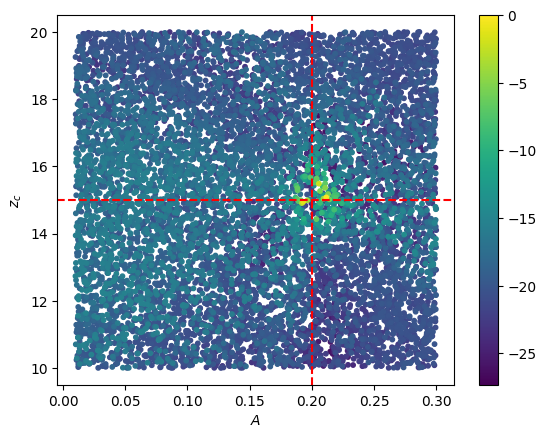

In [9]:

samples = prior(10000)
norm_params = (samples - theta.mean(axis=0))/theta.std(axis=0)

# logL - log Z
r_values = __call__(true_signals, norm_params)
prior_volume = np.log(1/np.prod(theta_max - theta_min))
logP = r_values + prior_volume
args = np.argsort(logP)
samples = samples[args]
logP = logP[args]

cbar = plt.scatter(samples[:, 0], samples[:, 1], c=logP- logP.max(), s=10, cmap='viridis')
plt.axvline(true_params[0], color='r', linestyle='--')
plt.axhline(true_params[1], color='r', linestyle='--')
plt.colorbar(cbar)
plt.xlabel(r'$A$')
plt.ylabel(r'$z_c$')
plt.savefig('example_posterior.png', dpi=300, bbox_inches='tight')

